In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
from typing import Callable, Mapping, Tuple, TypeVar, Set

In [3]:
from src.mdps.in_class_maze_runner import BasicMazeRunner
from src.mdps.grid_maze import RandomGridMaze
from src.value_iteration.value_iteration_methods import value_iteration
from src.value_iteration.core import get_greedy_policy

# MDP from lecture

In [4]:
class_mr = BasicMazeRunner()
maze_runner_actions, maze_runner_transitions, maze_runner_rewards = class_mr.get_mdp()

In [5]:
# value iteration returns: base_value_function, num_iter, max_diffs, updates_per_iter
pure_vi, num_iter, _, _ = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9)
print('pure vi', pure_vi, num_iter)

random_k_vi, num_iter_random_k, rk_convergence, _ = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='random-k', k=3, log_converence=True, gt_vf=pure_vi)
print('random k', random_k_vi, num_iter_random_k)
print(rk_convergence)

tree_vi, num_iter_tree, it_convergence, _ = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='influence-tree', log_converence=True, gt_vf=pure_vi)
print('influence tree', tree_vi, num_iter_tree)

cyclic_vi, num_iter_cyclic,cvi_convergence, _ = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='cyclic-vi', log_converence=True, gt_vf=pure_vi)
print('cyclic vi', cyclic_vi, num_iter_cyclic)

rp_cyclic_vi, rp_num_iter_cyclic, c_vi_rp_convergence, _ = value_iteration(actions=maze_runner_actions, transitions=maze_runner_transitions, rewards=maze_runner_rewards,
               discount=0.9, vi_method='cyclic-vi-rp', log_converence=True, gt_vf=pure_vi)
print('random permut cyclic', rp_cyclic_vi, rp_num_iter_cyclic)


pure vi {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2
random k {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 3
[1.0, 1.0, 0.0]
influence tree {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2
cyclic vi {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2
random permut cyclic {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 1.0, 5: 0.0} 2


# 2D Maze environment

In [6]:
def plot_5_cases(maze_actions, maze_transitions, maze_rewards, terminal_maze_state ,fig, idx, num_cases, na):

    pure_vi, num_iter, _, _ = value_iteration(actions=maze_actions, transitions=maze_transitions, \
                                              rewards=maze_rewards,
                   discount=0.9)
    policy_p_vi = get_greedy_policy(value_function=pure_vi, actions=maze_actions, transitions=\
                                    maze_transitions, rewards=maze_rewards,
                   terminal_states=set(terminal_maze_state), discount=0.9)
    pure_vi_2, num_iter, vi_convergence, updates_per_iter = value_iteration(actions=maze_actions, \
                                                                            transitions=maze_transitions, rewards=maze_rewards,
                   discount=0.9, log_converence=True, gt_vf=pure_vi)
    j = 1
    ax = fig.add_subplot(5, num_cases, (j-1)*num_cases+idx)
    ax.set_title('value iteration, %d actions'%na)
    ax.set_ylabel('inf norm vs v^*')
    ax.set_xlabel('iterations')
    ax.plot(vi_convergence, color='b', label='VI convergence')
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.set_ylabel('number of states updated per iteration')
    ax2.plot(updates_per_iter, ':',color='r', label='# of updates')
    ax2.legend(loc="upper right")


    k_vi, k_num_iter, rk_convergence, updates_per_iter = value_iteration(actions=maze_actions, \
                                transitions=maze_transitions, rewards=maze_rewards,
                   discount=0.9, vi_method='random-k', k=10, log_converence=True, gt_vf=pure_vi)
    policy_k_vi = get_greedy_policy(value_function=k_vi, actions=maze_actions, transitions=\
                                maze_transitions, rewards=maze_rewards,
                   terminal_states=set(terminal_maze_state), discount=0.9)
    j = 2
    ax = fig.add_subplot(5, num_cases, (j-1)*num_cases+idx)
    ax.set_title('random k value iteration, %d actions'%na)
    ax.set_ylabel('inf norm vs v^*')
    ax.set_xlabel('iterations')
    ax.plot(rk_convergence, color='b', label='VI convergence')
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.set_ylabel('number of states updated per iteration')
    ax2.plot(updates_per_iter, ':',color='r', label='# of updates')
    ax2.legend(loc="upper right")


    tree_vi, tree_num_iter, it_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
                   discount=0.9, vi_method='influence-tree', log_converence=True, gt_vf=pure_vi)
    policy_tree_vi = get_greedy_policy(value_function=tree_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
                   terminal_states=set(terminal_maze_state), discount=0.9)
    j = 3
    ax = fig.add_subplot(5, num_cases, (j-1)*num_cases+idx)
    ax.set_title('tree value iteration, %d actions'%na)
    ax.set_ylabel('inf norm vs v^*')
    ax.set_xlabel('iterations')
    ax.plot(it_convergence, color='b', label='VI convergence')
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.set_ylabel('number of states updated per iteration')
    ax2.plot(updates_per_iter, ':',color='r', label='# of updates')
    ax2.legend(loc="upper right")


    cyclic_vi, cyclic_num_iter, cvi_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
                   discount=0.9, vi_method='cyclic-vi', log_converence=True, gt_vf=pure_vi)
    policy_cyclic_vi = get_greedy_policy(value_function=cyclic_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
                   terminal_states=set(terminal_maze_state), discount=0.9)
    j = 4
    ax = fig.add_subplot(5, num_cases, (j-1)*num_cases+idx)
    ax.set_title('cyclic value iteration, %d actions'%na)
    ax.set_ylabel('inf norm vs v^*')
    ax.set_xlabel('iterations')
    ax.plot(cvi_convergence, color='b', label='VI convergence')
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.set_ylabel('number of states updated per iteration')
    ax2.plot(updates_per_iter, ':',color='r', label='# of updates')
    ax2.legend(loc="upper right")

    rp_cyclic_vi, rp_cyclic_num_iter, c_vi_rp_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
                   discount=0.9, vi_method='cyclic-vi-rp', log_converence=True, gt_vf=pure_vi)
    rp_policy_cyclic_vi = get_greedy_policy(value_function=rp_cyclic_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
                   terminal_states=set(terminal_maze_state), discount=0.9)
    j = 5
    ax = fig.add_subplot(5, num_cases, (j-1)*num_cases+idx)
    ax.set_title('random permutation cyclic VI, %d actions'%na)
    ax.set_ylabel('inf norm vs v^*')
    ax.set_xlabel('iterations')
    ax.plot(c_vi_rp_convergence, color='b', label='VI convergence')
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.set_ylabel('number of states updated per iteration')
    ax2.plot(updates_per_iter, ':',color='r', label='# of updates')
    ax2.legend(loc="upper right")

    fig.tight_layout(pad=3.0)


## Comparison against 5 approaches: 
## Normal VI, Random VI, Influence Tree, Cyclic VI, Random Cyclic VI

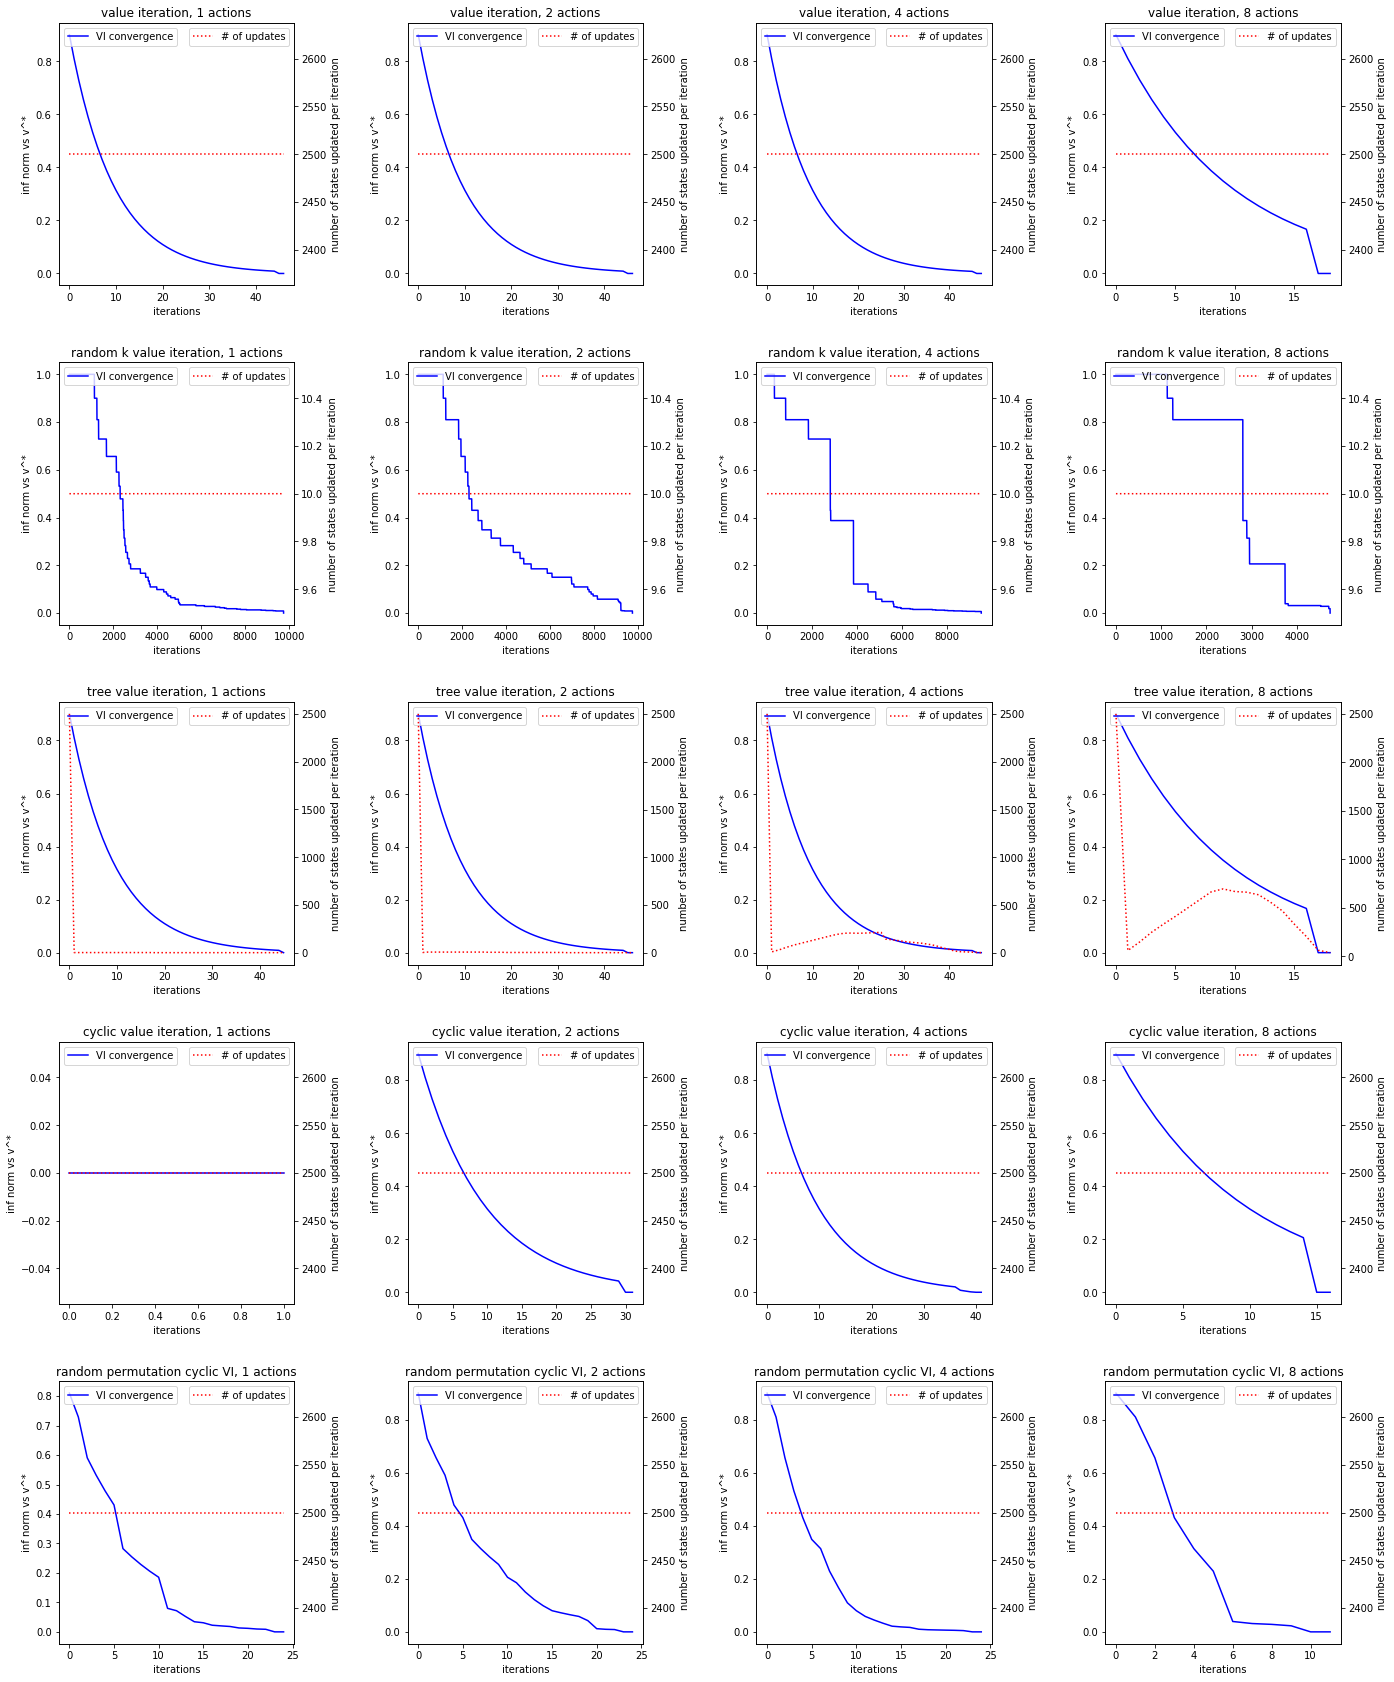

In [7]:
num_actions = [1,2,4,8]
fig = plt.figure(figsize=(20,24))

for idx, na in enumerate(num_actions):
    maze = RandomGridMaze(50,50, 4, num_actions=na, seed=0)
    maze_actions, maze_transitions, maze_rewards, terminal_maze_state = maze.get_mdp()
    
    plot_5_cases(maze_actions, maze_transitions, maze_rewards, terminal_maze_state, \
                        fig, idx+1, len(num_actions), na)
    
plt.show()

## Influence tree. Sparsity comparison

In [19]:
def plot_influence_tree(maze_actions, maze_transitions, maze_rewards, terminal_maze_state, fig,\
                        idx, num_cases, na):

    tree_vi, tree_num_iter, it_convergence, updates_per_iter = value_iteration(actions=maze_actions, \
                    transitions=maze_transitions, rewards=maze_rewards,
                   discount=0.9, vi_method='influence-tree', log_converence=True, gt_vf=pure_vi)
    policy_tree_vi = get_greedy_policy(value_function=tree_vi, actions=maze_actions, transitions=\
                    maze_transitions, rewards=maze_rewards,
                   terminal_states=set(terminal_maze_state), discount=0.9)
    ax = fig.add_subplot(1,num_cases, idx)
    ax.set_title('tree value iteration, %d actions'%na)
    ax.set_ylabel('inf norm vs v^*')
    ax.set_xlabel('iterations')
    ax.plot(it_convergence, color='b', label='VI convergence')
    ax.legend(loc="upper left")

    ax2 = ax.twinx()
    ax2.set_ylabel('number of states updated per iteration')
    ax2.plot(updates_per_iter, ':',color='r', label='# of updates')
    ax2.legend(loc="upper right")

    fig.tight_layout(pad=2.0)

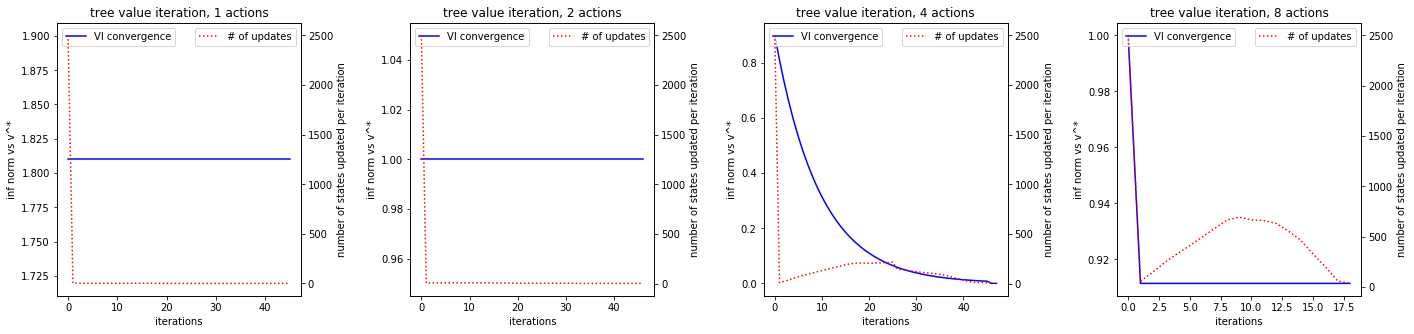

In [23]:
num_actions = [1,2,4,8]
fig = plt.figure(figsize=(20,5))

for idx, na in enumerate(num_actions):
    maze = RandomGridMaze(50,50, 4, num_actions=na, seed=0)
    maze_actions, maze_transitions, maze_rewards, terminal_maze_state = maze.get_mdp()

    plot_influence_tree(maze_actions, maze_transitions, maze_rewards, terminal_maze_state, \
                        fig, idx+1, len(num_actions), na)
    
plt.show()

# Maze 2D. Sven's visualization

In [13]:
maze = RandomGridMaze(50, 50, 4, num_actions=4, seed=0)
maze_actions, maze_transitions, maze_rewards, terminal_maze_state = maze.get_mdp()

cyclic random permute


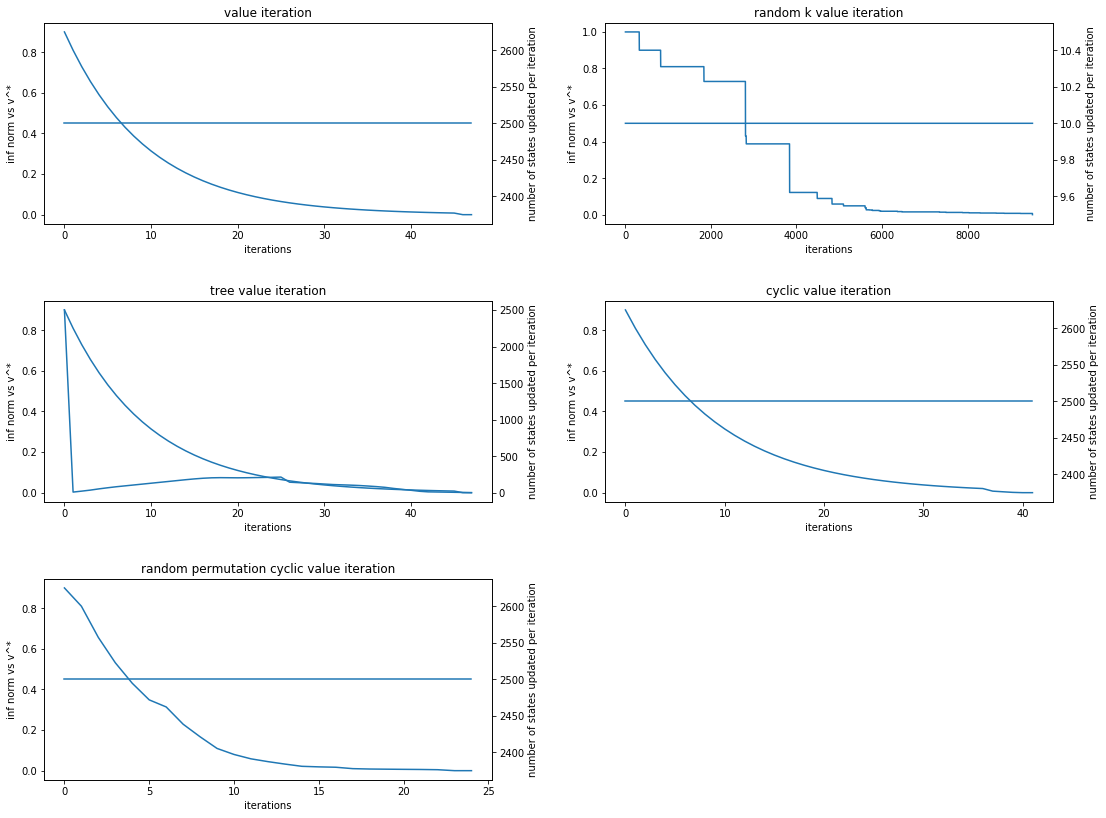

In [14]:
fig = plt.figure(figsize=(16,12))

pure_vi, num_iter, _, _ = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9)
# print(pure_vi)
# print(num_iter)
policy_p_vi = get_greedy_policy(value_function=pure_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
# print(policy_p_vi)
# print()
pure_vi_2, num_iter, vi_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, log_converence=True, gt_vf=pure_vi)
ax = fig.add_subplot(3, 2, 1)
ax.set_title('value iteration')
ax.set_ylabel('inf norm vs v^*')
ax.set_xlabel('iterations')
ax.plot(vi_convergence)

ax2 = ax.twinx()
ax2.set_ylabel('number of states updated per iteration')
ax2.plot(updates_per_iter)


k_vi, k_num_iter, rk_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='random-k', k=10, log_converence=True, gt_vf=pure_vi)
policy_k_vi = get_greedy_policy(value_function=k_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
ax = fig.add_subplot(3, 2, 2)
ax.set_title('random k value iteration')
ax.set_ylabel('inf norm vs v^*')
ax.set_xlabel('iterations')
ax.plot(rk_convergence)

ax2 = ax.twinx()
ax2.set_ylabel('number of states updated per iteration')
ax2.plot(updates_per_iter)


tree_vi, tree_num_iter, it_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='influence-tree', log_converence=True, gt_vf=pure_vi)
policy_tree_vi = get_greedy_policy(value_function=tree_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
ax = fig.add_subplot(3, 2, 3)
ax.set_title('tree value iteration')
ax.set_ylabel('inf norm vs v^*')
ax.set_xlabel('iterations')
ax.plot(it_convergence)

ax2 = ax.twinx()
ax2.set_ylabel('number of states updated per iteration')
ax2.plot(updates_per_iter)


cyclic_vi, cyclic_num_iter, cvi_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='cyclic-vi', log_converence=True, gt_vf=pure_vi)
policy_cyclic_vi = get_greedy_policy(value_function=cyclic_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
ax = fig.add_subplot(3, 2, 4)
ax.set_title('cyclic value iteration')
ax.set_ylabel('inf norm vs v^*')
ax.set_xlabel('iterations')
ax.plot(cvi_convergence)

ax2 = ax.twinx()
ax2.set_ylabel('number of states updated per iteration')
ax2.plot(updates_per_iter)

print('cyclic random permute')
rp_cyclic_vi, rp_cyclic_num_iter, c_vi_rp_convergence, updates_per_iter = value_iteration(actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               discount=0.9, vi_method='cyclic-vi-rp', log_converence=True, gt_vf=pure_vi)
rp_policy_cyclic_vi = get_greedy_policy(value_function=rp_cyclic_vi, actions=maze_actions, transitions=maze_transitions, rewards=maze_rewards,
               terminal_states=set(terminal_maze_state), discount=0.9)
ax = fig.add_subplot(3, 2, 5)
ax.set_title('random permutation cyclic value iteration')
ax.set_ylabel('inf norm vs v^*')
ax.set_xlabel('iterations')
ax.plot(c_vi_rp_convergence)

ax2 = ax.twinx()
ax2.set_ylabel('number of states updated per iteration')
ax2.plot(updates_per_iter)

fig.tight_layout(pad=3.0)

plt.show()